<a href="https://colab.research.google.com/github/erinmcmahon26/NLP-Chat-Bot/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ingest Data and Import Libraries

In [22]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

In [23]:
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [24]:
#not sure I need this - try next time I run what happens
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

Cleaning functions

In [25]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = stopwords.words('english')
    new_words = ['movie','story']
    stop_words.extend(new_words)
    all_stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in all_stop_words]         
    # word stemming    
    #ps=PorterStemmer()
    #tokens=[ps.stem(word) for word in tokens]
    # lemmatize
    wnl = WordNetLemmatizer()
    tokens=[wnl.lemmatize(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range):
    #this is a function to create the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating dataframe from TFIDF Matrix
    words = Tfidf.get_feature_names_out()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix ,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

In [26]:
#read in class corpus csv into python
data=pd.read_csv(r'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_Sec57_2202_ClassCorpus_v2.csv')

In [27]:
data.head()

Doc_ID               DSI_Title Student Name Genre of Movie  \
0       1  EMU_Doc1_TheConjuring3          EMU         Horror   
1       2  EMU_Doc2_TheConjuring3          EMU         Horror   
2       3  EMU_Doc3_TheConjuring3          EMU         Horror   
3       4  EMU_Doc4_TheConjuring3          EMU         Horror   
4       5  EMU_Doc5_TheConjuring3          EMU         Horror   

  Review Type (pos or neg)      Movie Title  \
0                 Negative  The Conjuring 3   
1                 Positive  The Conjuring 3   
2                 Positive  The Conjuring 3   
3                 Positive  The Conjuring 3   
4                 Positive  The Conjuring 3   

                                                Text  
0  I must admit that when I sat down to watch the...  
1  While The Conjuring franchise has stood as one...  
2  We’re well into the world and the lore of the ...  
3  James Wan's 2013 feature The Conjuring was som...  
4  Two Conjuring films and several spinoffs estab...

### EDA 

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Doc_ID                    200 non-null    int64 
 1   DSI_Title                 200 non-null    object
 2   Student Name              200 non-null    object
 3   Genre of Movie            200 non-null    object
 4   Review Type (pos or neg)  200 non-null    object
 5   Movie Title               200 non-null    object
 6   Text                      200 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.1+ KB


In [29]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

In [30]:
type(processed_text)

list

In [31]:
data.head()

Doc_ID               DSI_Title Student Name Genre of Movie  \
0       1  EMU_Doc1_TheConjuring3          EMU         Horror   
1       2  EMU_Doc2_TheConjuring3          EMU         Horror   
2       3  EMU_Doc3_TheConjuring3          EMU         Horror   
3       4  EMU_Doc4_TheConjuring3          EMU         Horror   
4       5  EMU_Doc5_TheConjuring3          EMU         Horror   

  Review Type (pos or neg)      Movie Title  \
0                 Negative  The Conjuring 3   
1                 Positive  The Conjuring 3   
2                 Positive  The Conjuring 3   
3                 Positive  The Conjuring 3   
4                 Positive  The Conjuring 3   

                                                Text  \
0  I must admit that when I sat down to watch the...   
1  While The Conjuring franchise has stood as one...   
2  We’re well into the world and the lore of the ...   
3  James Wan's 2013 feature The Conjuring was som...   
4  Two Conjuring films and several spinoffs estab...   

                                      processed_text  
0  [admit, watch, addition, conjuring, franchise,...  
1  [conjuring, franchise, stood, successful, impr...  
2  [world, warren, lorraine, fictional, version, ...  
3  [james, feature, conjuring, something, special...  
4  [conjuring, film, several, spinoffs, establish...

In [32]:
tfidf_matrix, tfidf_words = tfidf(final_processed_text, titles, ngram_range = (1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
tfidf_matrix

abandon  abandoned  abandoning  abandonment  \
EMU_Doc1_TheConjuring3               0.0        0.0         0.0          0.0   
EMU_Doc2_TheConjuring3               0.0        0.0         0.0          0.0   
EMU_Doc3_TheConjuring3               0.0        0.0         0.0          0.0   
EMU_Doc4_TheConjuring3               0.0        0.0         0.0          0.0   
EMU_Doc5_TheConjuring3               0.0        0.0         0.0          0.0   
...                                  ...        ...         ...          ...   
JLU_Doc6_JamesBondCasinoRoyale       0.0        0.0         0.0          0.0   
JLU_Doc7_JamesBondCasinoRoyale       0.0        0.0         0.0          0.0   
JLU_Doc8_JamesBondCasinoRoyale       0.0        0.0         0.0          0.0   
JLU_Doc9_JamesBondCasinoRoyale       0.0        0.0         0.0          0.0   
JLU_Doc10_JamesBondCasinoRoyale      0.0        0.0         0.0          0.0   

                                 abashed    abduct  abducted  abdulmateen  \
EMU_Doc1_TheConjuring3               0.0  0.000000       0.0          0.0   
EMU_Doc2_TheConjuring3               0.0  0.000000       0.0          0.0   
EMU_Doc3_TheConjuring3               0.0  0.000000       0.0          0.0   
EMU_Doc4_TheConjuring3               0.0  0.000000       0.0          0.0   
EMU_Doc5_TheConjuring3               0.0  0.000000       0.0          0.0   
...                                  ...       ...       ...          ...   
JLU_Doc6_JamesBondCasinoRoyale       0.0  0.033098       0.0          0.0   
JLU_Doc7_JamesBondCasinoRoyale       0.0  0.000000       0.0          0.0   
JLU_Doc8_JamesBondCasinoRoyale       0.0  0.000000       0.0          0.0   
JLU_Doc9_JamesBondCasinoRoyale       0.0  0.000000       0.0          0.0   
JLU_Doc10_JamesBondCasinoRoyale      0.0  0.000000       0.0          0.0   

                                 abel  aberrance  ...  òpostmodernism  \
EMU_Doc1_TheConjuring3            0.0        0.0  ...             0.0   
EMU_Doc2_TheConjuring3            0.0        0.0  ...             0.0   
EMU_Doc3_TheConjuring3            0.0        0.0  ...             0.0   
EMU_Doc4_TheConjuring3            0.0        0.0  ...             0.0   
EMU_Doc5_TheConjuring3            0.0        0.0  ...             0.0   
...                               ...        ...  ...             ...   
JLU_Doc6_JamesBondCasinoRoyale    0.0        0.0  ...             0.0   
JLU_Doc7_JamesBondCasinoRoyale    0.0        0.0  ...             0.0   
JLU_Doc8_JamesBondCasinoRoyale    0.0        0.0  ...             0.0   
JLU_Doc9_JamesBondCasinoRoyale    0.0        0.0  ...             0.0   
JLU_Doc10_JamesBondCasinoRoyale   0.0        0.0  ...             0.0   

                                 òthatõs  òthis  òundefinable  òwere  òzeroó  \
EMU_Doc1_TheConjuring3               0.0    0.0           0.0    0.0     0.0   
EMU_Doc2_TheConjuring3               0.0    0.0           0.0    0.0     0.0   
EMU_Doc3_TheConjuring3               0.0    0.0           0.0    0.0     0.0   
EMU_Doc4_TheConjuring3               0.0    0.0           0.0    0.0     0.0   
EMU_Doc5_TheConjuring3               0.0    0.0           0.0    0.0     0.0   
...                                  ...    ...           ...    ...     ...   
JLU_Doc6_JamesBondCasinoRoyale       0.0    0.0           0.0    0.0     0.0   
JLU_Doc7_JamesBondCasinoRoyale       0.0    0.0           0.0    0.0     0.0   
JLU_Doc8_JamesBondCasinoRoyale       0.0    0.0           0.0    0.0     0.0   
JLU_Doc9_JamesBondCasinoRoyale       0.0    0.0           0.0    0.0     0.0   
JLU_Doc10_JamesBondCasinoRoyale      0.0    0.0           0.0    0.0     0.0   

                                 ógustave  überproducer  überstarman  þórarinn  
EMU_Doc1_TheConjuring3                0.0           0.0          0.0       0.0  
EMU_Doc2_TheConjuring3                0.0           0.0          0.0       0.0  
EMU_Doc3_TheConjuring3                0.0           0.0          0

In [34]:
print(len(tfidf_words))
type(tfidf_words)

13965


numpy.ndarray

### Modeling

#### LSA (Latent Semantic Analysis)

In [35]:
# create document-term matirx and dictionary terms for corpus
def prep_corpus(clean_doc):
    # Creating the term dictionary of the courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(clean_doc)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_doc]
    return dictionary, doc_term_matrix
  

In [36]:
# create lsa model
def lsa_model(clean_doc, number_of_topics, words):
  dictionary, doc_term_matrix = prep_corpus(clean_doc)
  lsa = LsiModel(doc_term_matrix, num_topics= number_of_topics, id2word= dictionary)
  return lsa

Coherence scores are calculated to determine an optimum number of topics

In [41]:
def compute_coherence_values(dictionary, doc_term_matrix, clean_doc, stop, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=clean_doc, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [53]:
def plot_coh_vals(clean_doc, start, stop, step):
    dictionary,doc_term_matrix=prep_corpus(clean_doc)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, clean_doc, stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.grid()
    plt.show()

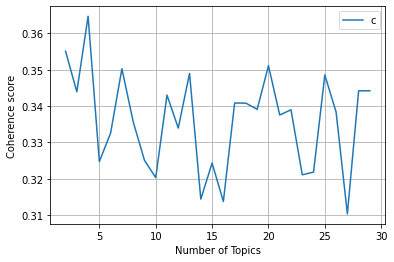

In [55]:
number_of_topics = 30
plot_coh_vals(processed_text, 2, 30, 1)

Based off of this plot, it looks like the number of topics to pick are either 4 (the highest coherence value) or 20 (second highest coherence value). Both of these topic amounts make sense as there are 4 genres and 20 movies in the corpus. 

In [51]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10, n_iter=100)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 30))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

[(0, '0.483*"movie" + 0.206*"character" + 0.160*"story" + 0.133*"first" + 0.122*"cruella" + 0.119*"film" + 0.114*"would" + 0.114*"scene" + 0.109*"action" + 0.109*"world"'), (1, '-0.736*"cruella" + 0.267*"movie" + -0.157*"baroness" + -0.156*"estella" + -0.150*"story" + -0.146*"stone" + -0.131*"character" + -0.122*"fashion" + -0.119*"thompson" + -0.110*"villain"'), (2, '0.462*"anderson" + -0.401*"movie" + 0.284*"budapest" + 0.277*"grand" + 0.266*"hotel" + 0.192*"gustave" + 0.147*"andersonõs" + -0.109*"cruella" + 0.108*"world" + 0.101*"film"'), (3, '-0.357*"movie" + 0.289*"mission" + 0.220*"impossible" + 0.208*"cruise" + 0.202*"casino" + -0.201*"anderson" + 0.201*"royale" + 0.184*"action" + 0.182*"vesper" + 0.182*"fallout"')]


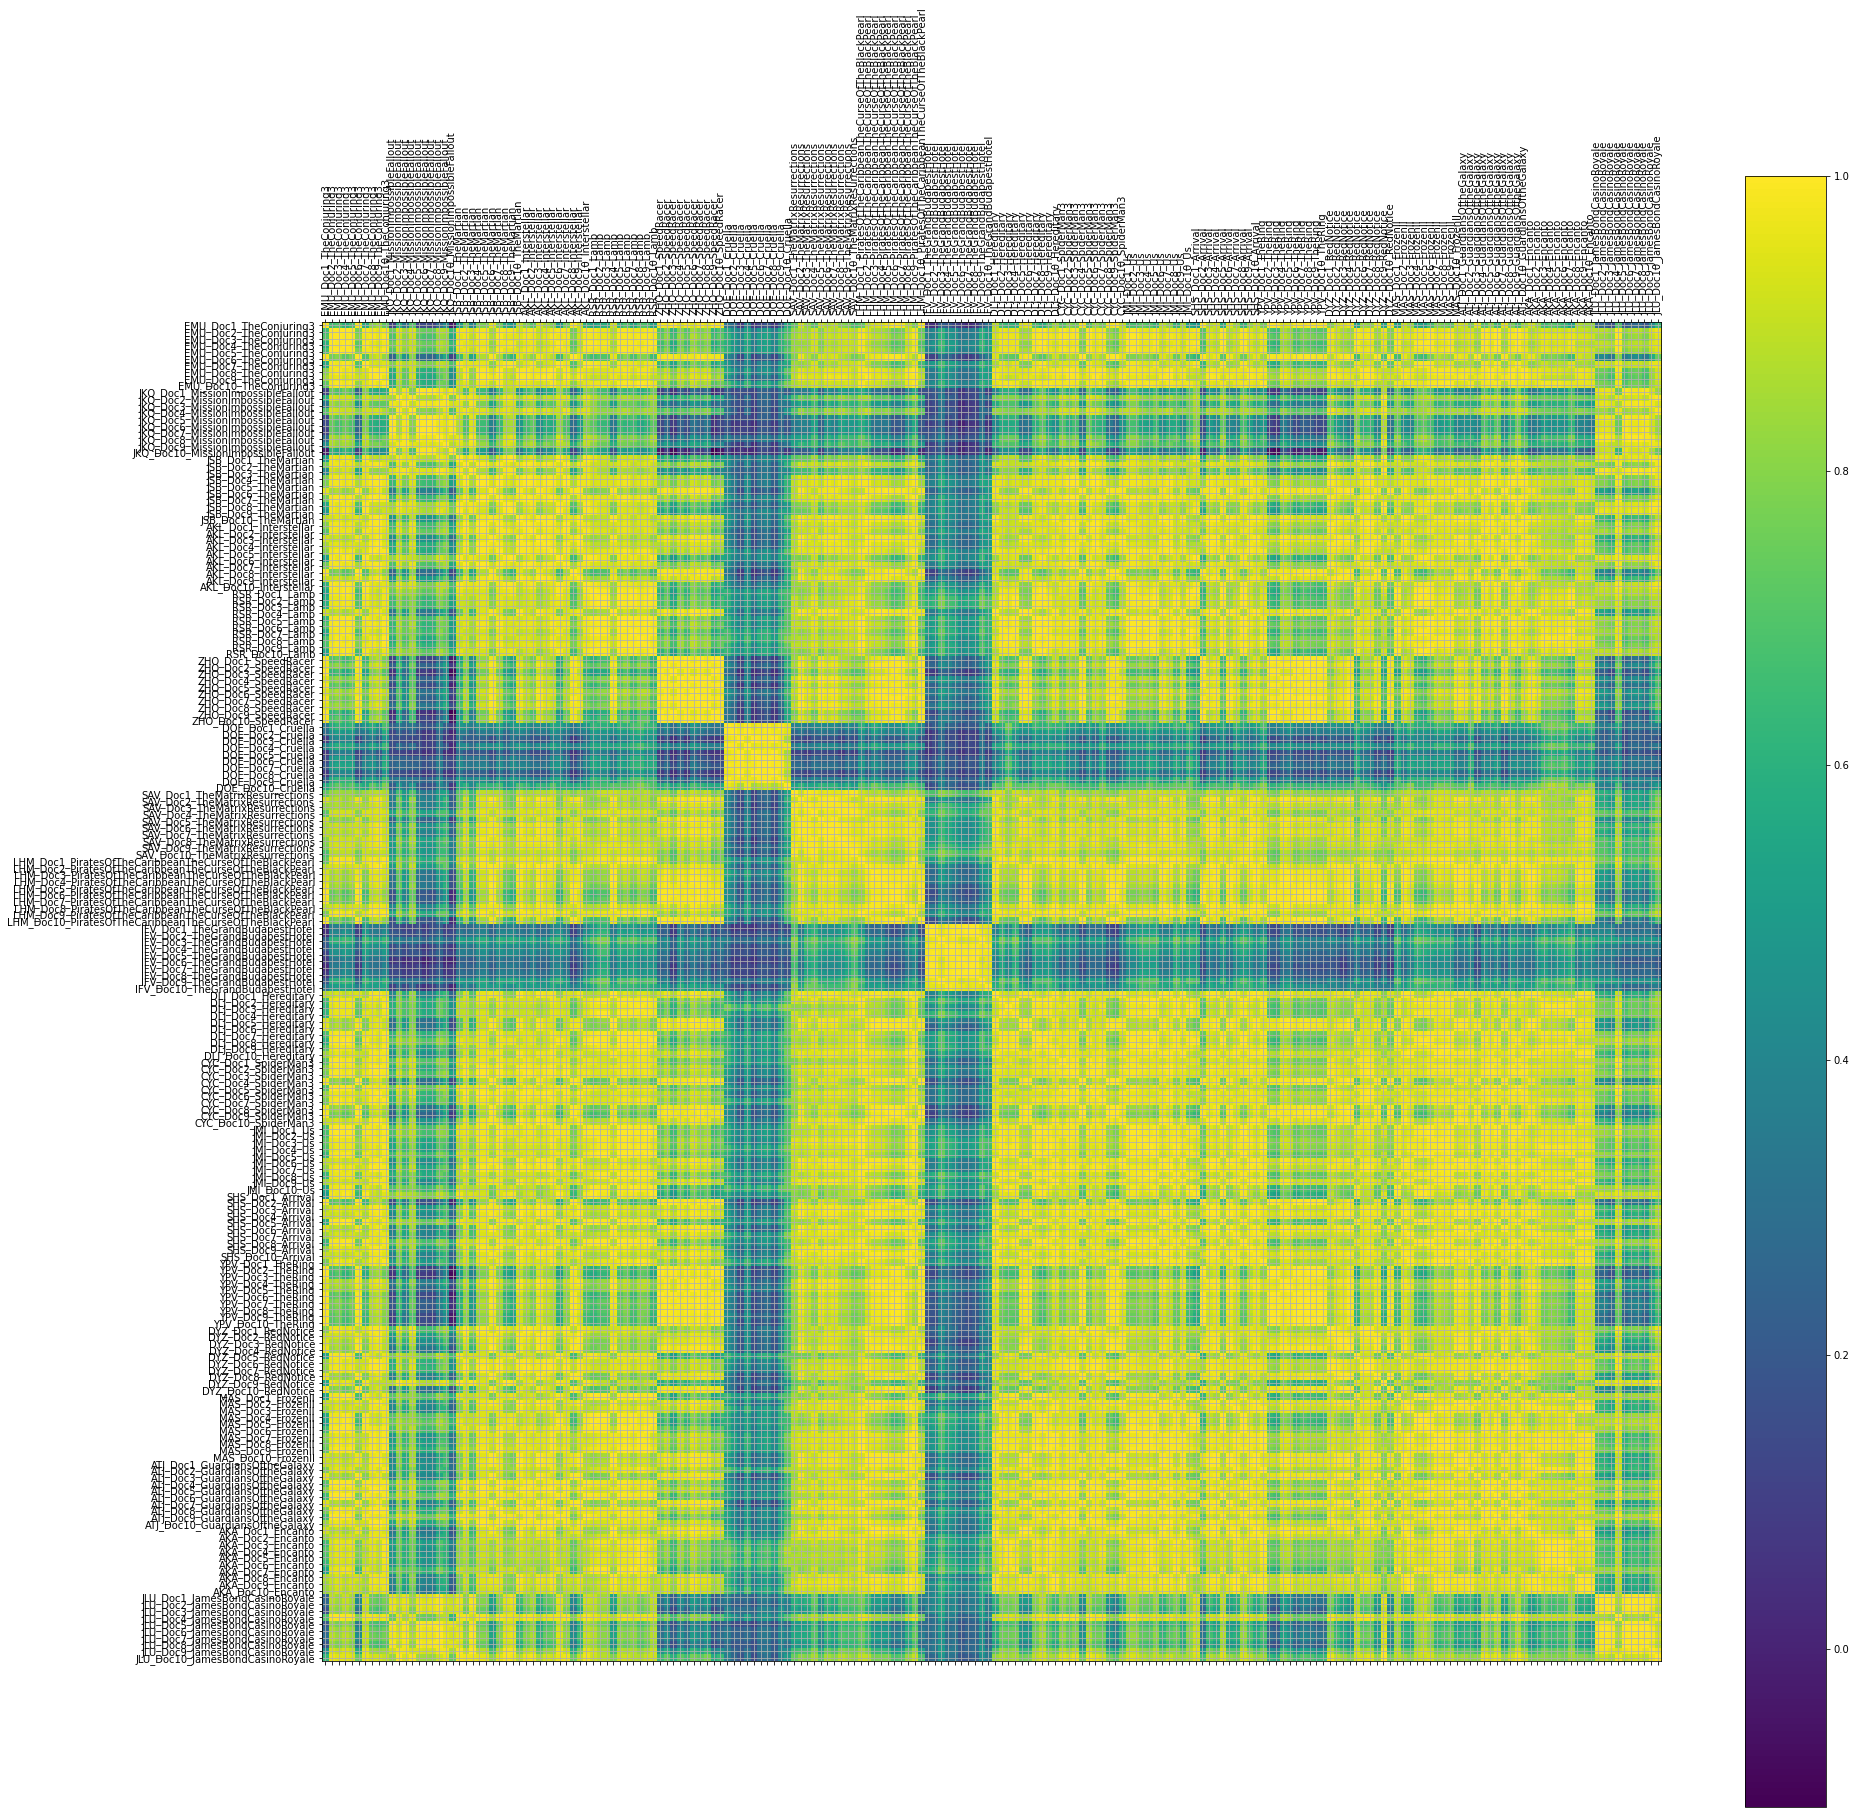

In [56]:
model_4topic_10words = plot_lsa(4,10)

[(0, '0.483*"movie" + 0.206*"character" + 0.160*"story" + 0.133*"first" + 0.122*"cruella" + 0.119*"film" + 0.114*"would" + 0.114*"scene" + 0.109*"action" + 0.109*"world"'), (1, '-0.736*"cruella" + 0.267*"movie" + -0.157*"baroness" + -0.156*"estella" + -0.149*"story" + -0.146*"stone" + -0.131*"character" + -0.122*"fashion" + -0.119*"thompson" + -0.110*"villain"'), (2, '-0.462*"anderson" + 0.401*"movie" + -0.284*"budapest" + -0.277*"grand" + -0.266*"hotel" + -0.192*"gustave" + -0.147*"andersonõs" + 0.109*"cruella" + -0.109*"world" + -0.101*"film"'), (3, '-0.357*"movie" + 0.289*"mission" + 0.220*"impossible" + 0.208*"cruise" + 0.202*"casino" + -0.201*"anderson" + 0.201*"royale" + 0.184*"action" + 0.182*"vesper" + 0.182*"fallout"'), (4, '0.385*"matrix" + 0.192*"mission" + 0.190*"action" + 0.185*"impossible" + -0.183*"casino" + 0.182*"cruise" + -0.182*"royale" + 0.171*"resurrection" + -0.171*"family" + -0.167*"vesper"'), (5, '-0.419*"matrix" + -0.255*"casino" + -0.251*"royale" + -0.232*"ves

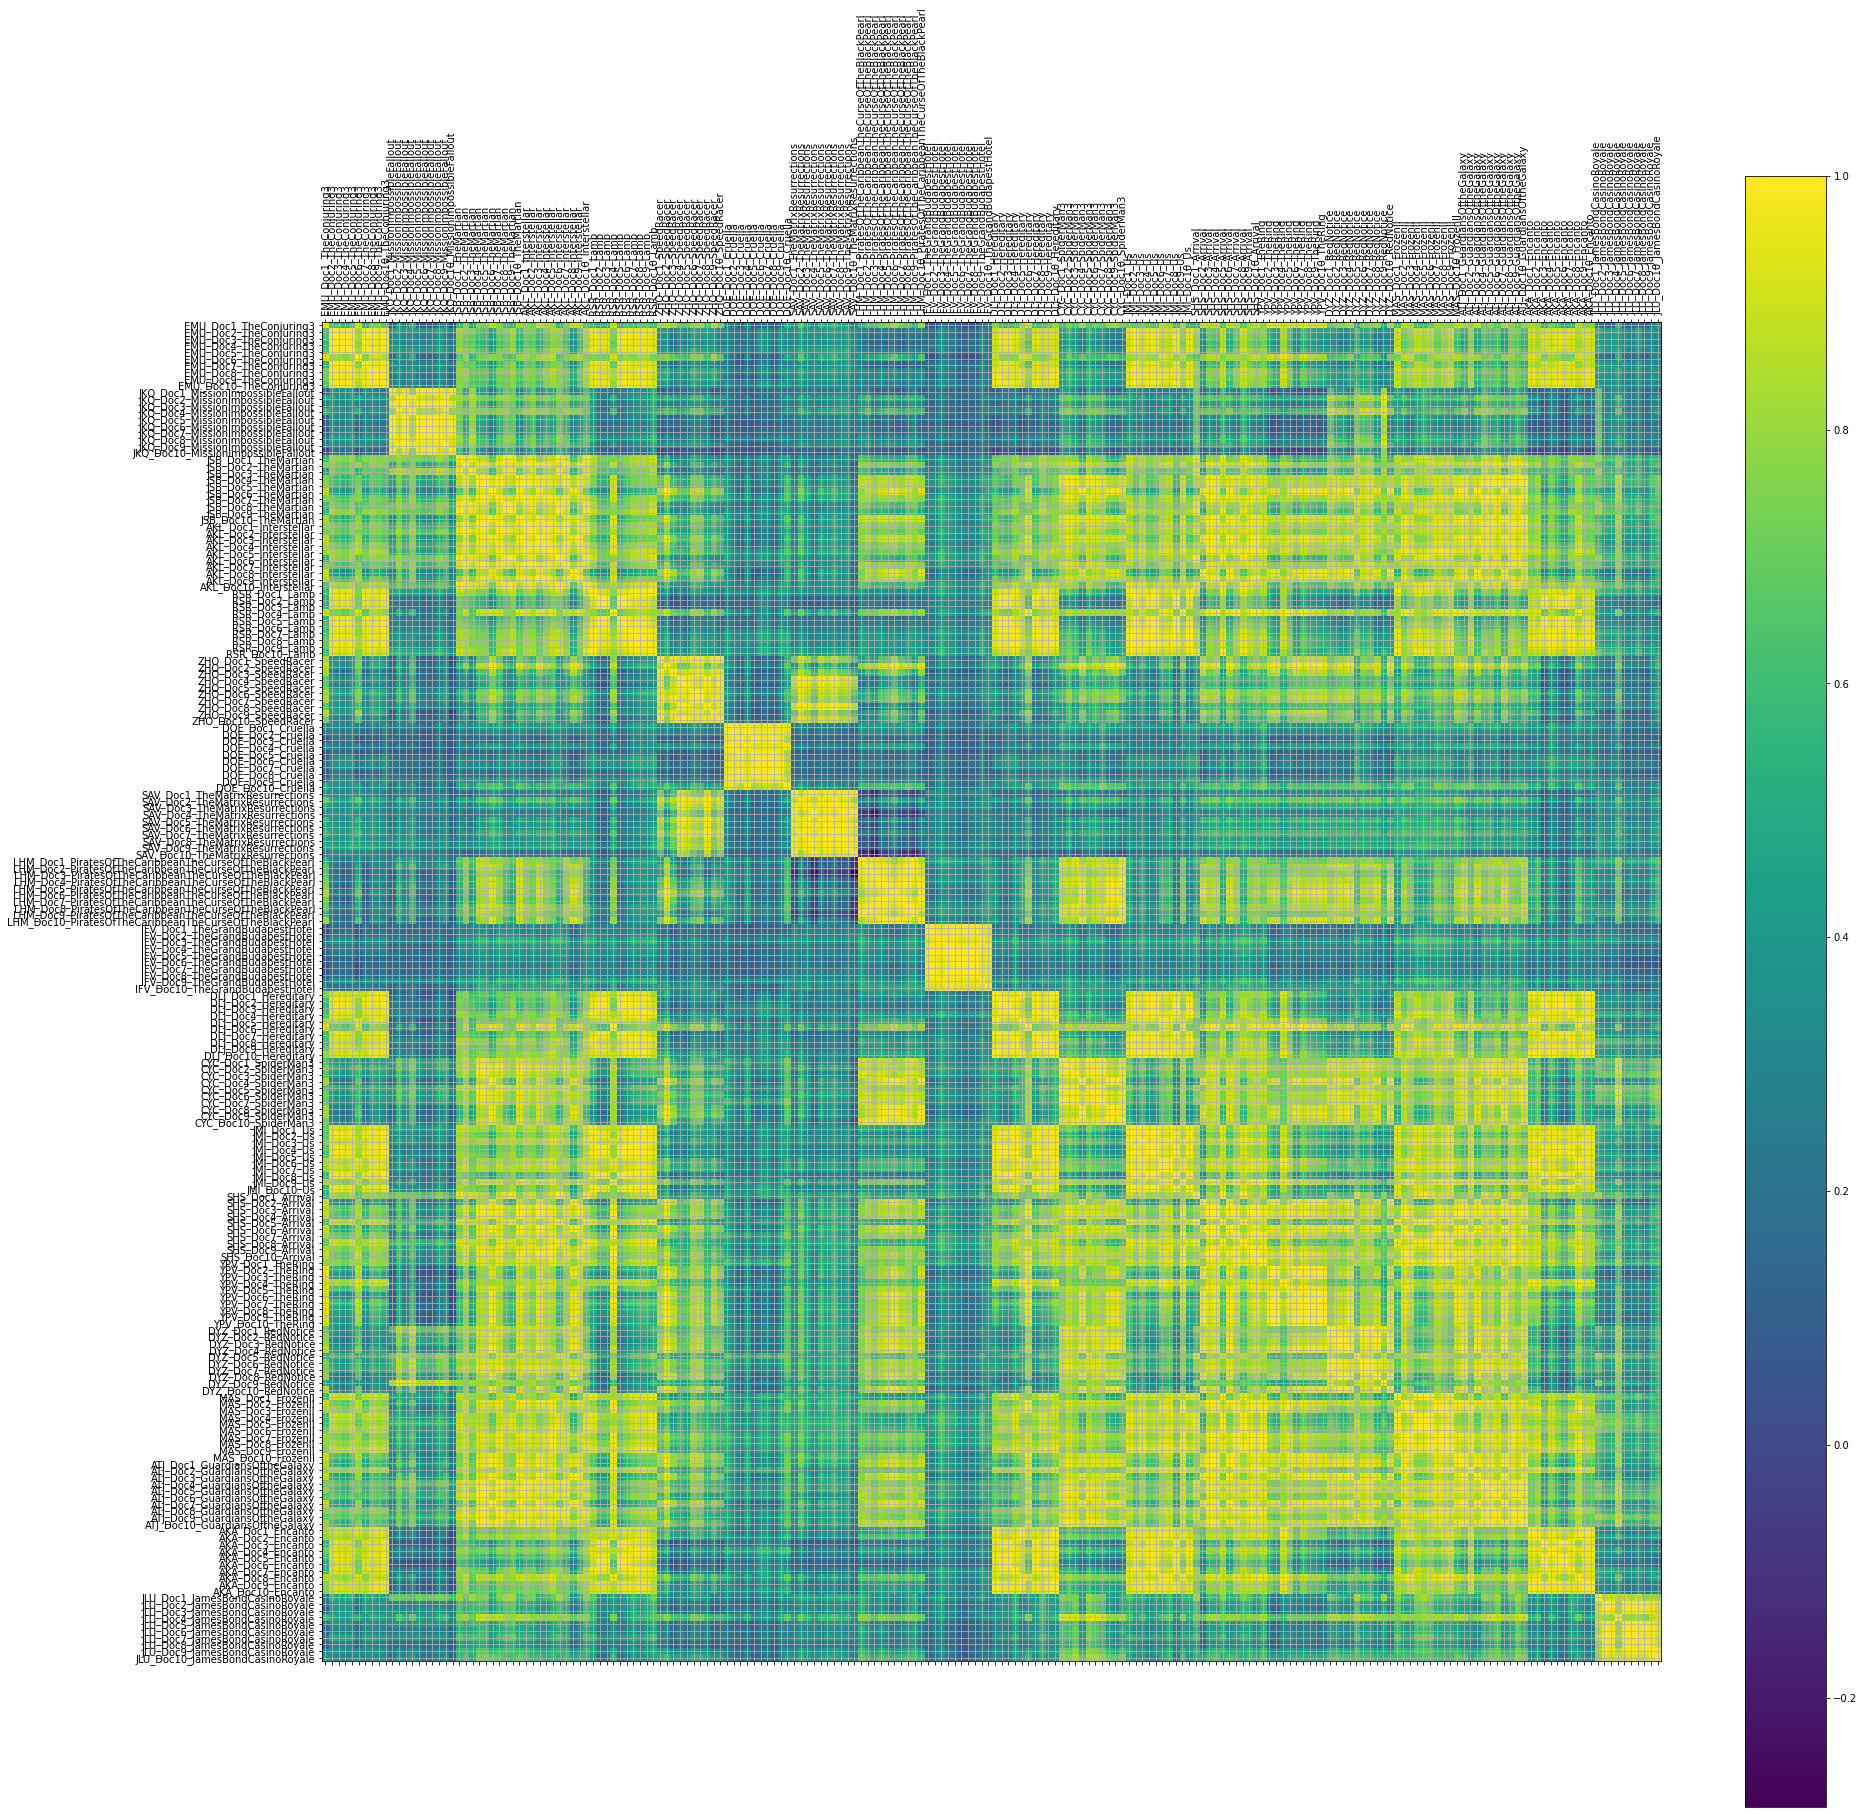

In [57]:
# was a possible close second highest coherence score from the plot
model_6topic_10words = plot_lsa(7, 10)

[(0, '-0.483*"movie" + -0.206*"character" + -0.160*"story" + -0.133*"first" + -0.122*"cruella" + -0.119*"film" + -0.114*"would" + -0.114*"scene" + -0.109*"action" + -0.109*"world"'), (1, '-0.736*"cruella" + 0.267*"movie" + -0.157*"baroness" + -0.156*"estella" + -0.150*"story" + -0.146*"stone" + -0.131*"character" + -0.122*"fashion" + -0.119*"thompson" + -0.110*"villain"'), (2, '-0.462*"anderson" + 0.401*"movie" + -0.284*"budapest" + -0.277*"grand" + -0.266*"hotel" + -0.192*"gustave" + -0.147*"andersonõs" + 0.109*"cruella" + -0.108*"world" + -0.101*"film"'), (3, '0.357*"movie" + -0.289*"mission" + -0.220*"impossible" + -0.208*"cruise" + -0.202*"casino" + 0.201*"anderson" + -0.201*"royale" + -0.184*"action" + -0.182*"vesper" + -0.182*"fallout"'), (4, '-0.385*"matrix" + -0.192*"mission" + -0.190*"action" + -0.185*"impossible" + 0.183*"casino" + -0.182*"cruise" + 0.182*"royale" + -0.171*"resurrection" + 0.171*"family" + 0.167*"vesper"'), (5, '0.419*"matrix" + 0.255*"casino" + 0.251*"royale

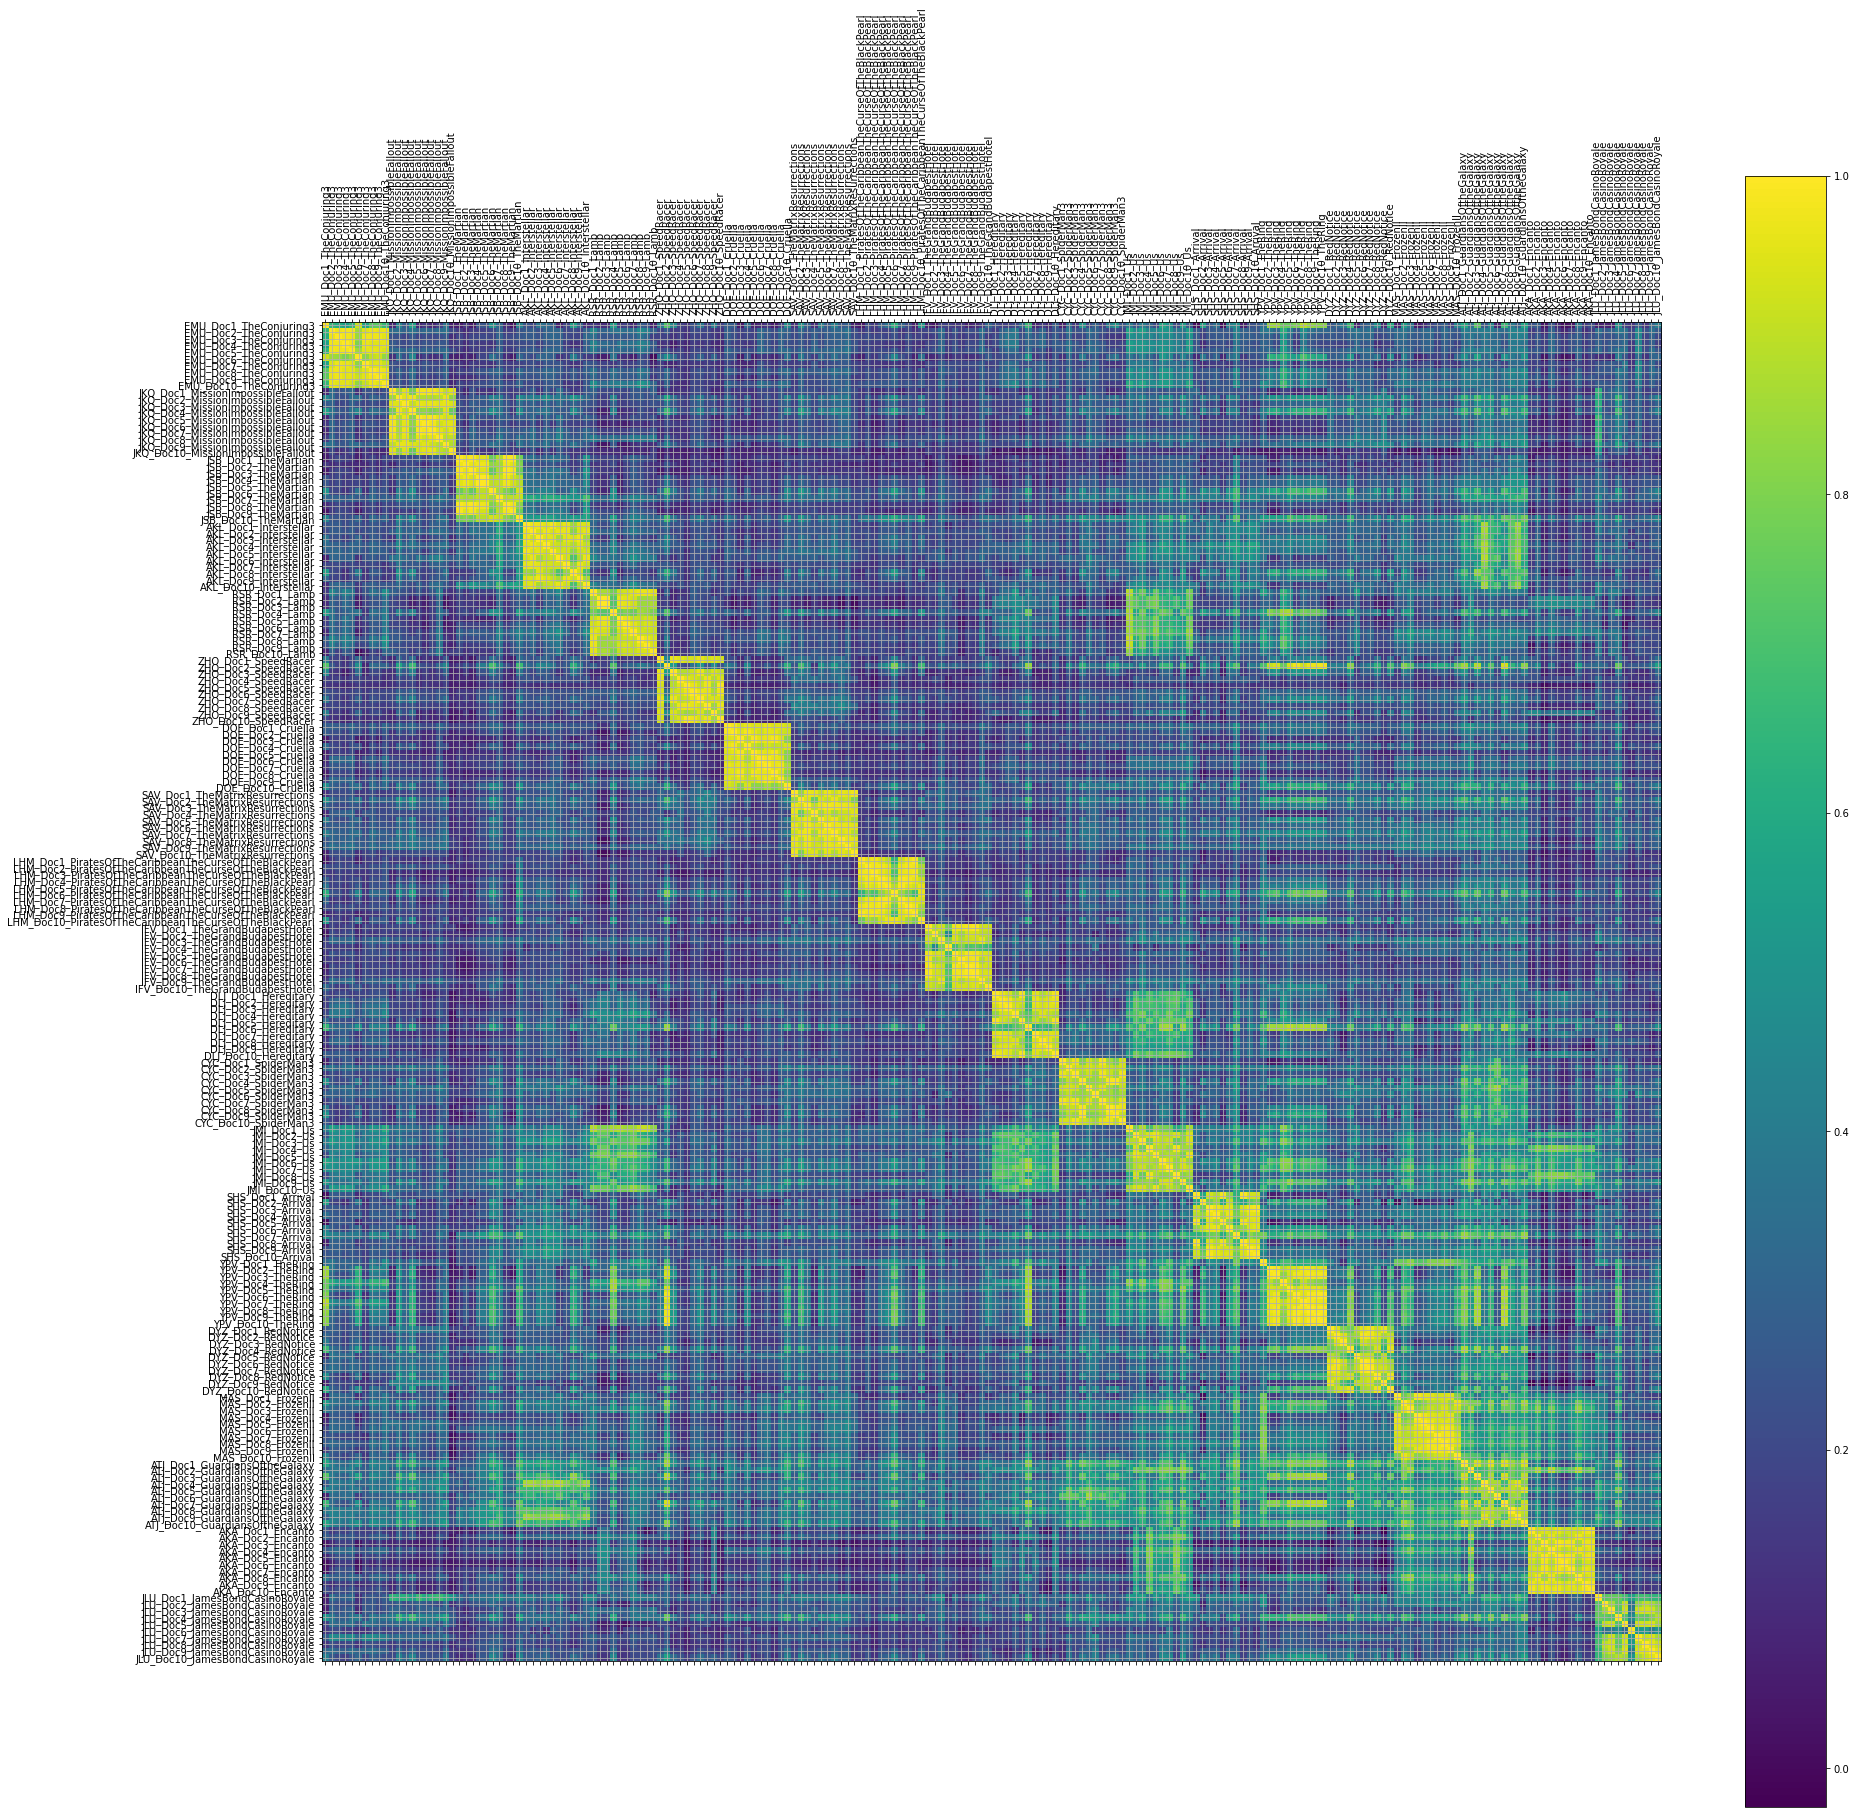

In [58]:
model_20topic_10words =plot_lsa(20, 10)

These heatmaps are based on weights from LSA, not cosine similarity. 

In [59]:
topics = [4, 7, 20]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'4 topics 10 words':coherence_values[0],
           '7 topics 10 words': coherence_values[1],
           '20 topics 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.483*"movie" + 0.206*"character" + 0.160*"story" + 0.133*"first" + 0.122*"cruella" + 0.119*"film" + 0.114*"would" + 0.114*"scene" + 0.109*"action" + 0.109*"world"'), (1, '-0.736*"cruella" + 0.267*"movie" + -0.157*"baroness" + -0.156*"estella" + -0.150*"story" + -0.146*"stone" + -0.131*"character" + -0.122*"fashion" + -0.119*"thompson" + -0.110*"villain"'), (2, '0.462*"anderson" + -0.401*"movie" + 0.284*"budapest" + 0.277*"grand" + 0.266*"hotel" + 0.192*"gustave" + 0.147*"andersonõs" + -0.109*"cruella" + 0.108*"world" + 0.101*"film"'), (3, '0.357*"movie" + -0.289*"mission" + -0.221*"impossible" + -0.208*"cruise" + -0.202*"casino" + 0.201*"anderson" + -0.201*"royale" + -0.184*"action" + -0.182*"vesper" + -0.182*"fallout"')]
[(0, '0.483*"movie" + 0.206*"character" + 0.160*"story" + 0.133*"first" + 0.122*"cruella" + 0.119*"film" + 0.114*"would" + 0.114*"scene" + 0.109*"action" + 0.109*"world"'), (1, '0.736*"cruella" + -0.267*"movie" + 0.157*"baroness" + 0.156*"estella" + 0.150*"stor

#### LDA

In [86]:
id2word = corpora.Dictionary(processed_text)
texts = processed_text

In [87]:
corpus = [id2word.doc2bow(text) for text in texts]

In [77]:
def lda_model(clean_doc, number_of_topics, words):
  dictionary, doc_term_matrix = prep_corpus(clean_doc)
  lda = LdaModel(doc_term_matrix, num_topics= number_of_topics, id2word= dictionary)
  return lda

In [71]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics, num_words):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

In [72]:
number_of_topics=4
words=10

In [ ]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics, words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [ ]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'6 topics 10 words':coherence_values[0],
           '2 topics 10 words': coherence_values[1],
           '20 topics 10 words':coherence_values[2]}   

print(coherence)

In [73]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [74]:
# this will be helpful
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=processed_text, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: ignored

In [61]:
#pip install pyldavis

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=f652be2a5e01150693cef946e88502d7b38bafd8aedd1845be09e73c535745d5
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis


In [67]:
import pyLDAvis
import pickle

In [69]:
import pyLDAvis.gensim_models

In [70]:
pyLDAvis.enable_notebook()

In [82]:
type(processed_text)

list

In [80]:
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, tokens, dictionary)

NameError: ignored

### Clustering Model Research

#### K-Means

Perform PCA for k-means to help with clustering.

In [ ]:
def k_means(titles, tfidf_matrix, k):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

In [ ]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =20)

In [ ]:
cluster_title[0]

In [ ]:
k_means_df

In [ ]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

In [ ]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

#### SVM, Naive Bayes, Random Forest

In [ ]:
def model_metrics(model, xtest, ytest):
  y_pred = model.predict(xtest)
  cm = confusion_matrix(ytest, y_pred)
  print("Accuracy Score:", accuracy_score(ytest, y_pred))
  print("Report:", classification_report(ytest, y_pred))
  sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")

In [ ]:
def param_selection(model, parameters, xtrain, ytrain):
  grid_search = RandomizedSearchCV(model, parameters, scoring='accuracy', cv=5, n_jobs=1)
  results = grid_search.fit(xtrain, ytrain)
  print('Mean Accuracy: %.3f' % results.best_score_)
  print('Config: %s' % results.best_params_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.20, random_state=42)

In [ ]:
# SVM
classifiers(tfidf_matrix, labels, 'svm')

In [ ]:
# Naive Bayes
classifiers(tfidf_matrix, labels, 'naive_bayes')

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=100, random_state = 777)
rfc.fit(X_train, y_train)

model_metrics(rfc, X_test, y_test)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = [{'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}]


param_selection(rfc, random_grid, X_train, y_train)